
# Camera → Avatar Latency Analysis

This notebook analyzes latency samples exported from Blender (one value per line, **seconds**), and compares your results with reference latencies from other systems.

**How to use**
1. Set the path to your CSV file below.
2. Run all cells. You'll get summary stats (mean/median/p95), bootstrap CIs, and plots (histogram & boxplot).
3. Optionally compare multiple CSVs (different conditions).


In [ ]:

# === Path to your latency CSV (one value per line, in seconds) ===
CSV_PATH = r"/content/exp2_blender_demo.csv"  # <- change to your file

import pandas as pd
import numpy as np

lat_s = pd.read_csv(CSV_PATH, header=None, names=["lat_s"]).dropna()
lat_s = lat_s[(lat_s["lat_s"]>=0) & (lat_s["lat_s"]<2.0)]  # sanity clamp
print(f"Loaded {len(lat_s)} samples from {CSV_PATH}")
lat_ms = lat_s["lat_s"] * 1000.0
lat_ms.describe(percentiles=[0.5,0.95])


Loaded 20880 samples from /content/exp2_blender_demo.csv


,lat_s
count,20880.000000
mean,40.538747
std,40.779802
min,0.000000
50%,26.198500
95%,136.586700
max,183.949000


In [ ]:

def summarize_latency_ms(series):
    series = series.dropna().astype(float)
    import numpy as np
    n = len(series)
    mean = series.mean()
    median = series.median()
    p95 = np.percentile(series, 95)
    p99 = np.percentile(series, 99) if n>=100 else float("nan")
    tail_150 = (series > 150.0).mean() * 100.0  # % of frames >150 ms
    return {
        "n": n, "mean_ms": mean, "median_ms": median, "p95_ms": p95, "p99_ms": p99, "tail_over_150_ms_%": tail_150
    }

summary = summarize_latency_ms(lat_ms)
summary


{'n': 20880,
 'mean_ms': np.float64(40.53874655172414),
 'median_ms': 26.198500000000003,
 'p95_ms': np.float64(136.5867),
 'p99_ms': np.float64(156.94208999999995),
 'tail_over_150_ms_%': np.float64(1.992337164750958)}

In [ ]:

# === Bootstrap 95% CIs for mean, median, p95 ===
import numpy as np
rng = np.random.default_rng(42)
B = 1000

def bootstrap_ci(series, stat_fn, B=1000, alpha=0.05):
    arr = series.to_numpy().astype(float)
    n = len(arr)
    stats = []
    for _ in range(B):
        sample = rng.choice(arr, size=n, replace=True)
        stats.append(stat_fn(sample))
    lower = float(np.percentile(stats, 100*alpha/2))
    upper = float(np.percentile(stats, 100*(1-alpha/2)))
    return (lower, upper)

mean_ci   = bootstrap_ci(lat_ms, np.mean, B=B)
median_ci = bootstrap_ci(lat_ms, np.median, B=B)
p95_ci    = bootstrap_ci(lat_ms, lambda a: np.percentile(a,95), B=B)

print("Mean (ms):   {:.2f}  95% CI {}".format(summary["mean_ms"], mean_ci))
print("Median (ms): {:.2f}  95% CI {}".format(summary["median_ms"], median_ci))
print("p95 (ms):    {:.2f}  95% CI {}".format(summary["p95_ms"], p95_ci))


Mean (ms):   40.54  95% CI (39.96768213601533, 41.07701141882184)
Median (ms): 26.20  95% CI (25.784937499999998, 26.6093375)
p95 (ms):    136.59  95% CI (135.56449999999998, 137.61406874999997)


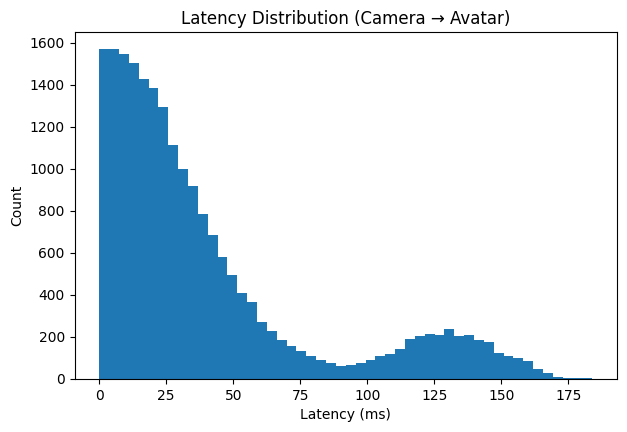

In [ ]:

# Histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4.5))
plt.hist(lat_ms, bins=50)
plt.xlabel("Latency (ms)")
plt.ylabel("Count")
plt.title("Latency Distribution (Camera → Avatar)")
plt.show()


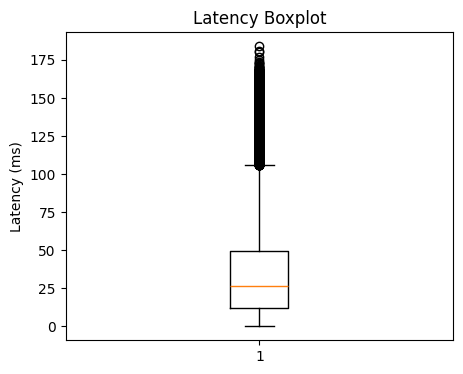

In [ ]:

# Boxplot
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.boxplot(lat_ms, vert=True, showfliers=True)
plt.ylabel("Latency (ms)")
plt.title("Latency Boxplot")
plt.show()



## Optional: Compare multiple runs / conditions
Add multiple CSVs (e.g., baseline, +hands, +head) to compare summaries and boxplots.


In [ ]:

# Map of label -> CSV path
FILES = {
    "baseline": CSV_PATH,
    # "with_hands": r"C:\path\to\with_hands.csv",
    # "with_head":  r"C:\path\to\with_head.csv",
}

import pandas as pd, numpy as np
rows = []
for label, path in FILES.items():
    try:
        s = pd.read_csv(path, header=None, names=["lat_s"])["lat_s"].dropna()
        s = s[(s>=0) & (s<2.0)]
        ms = s*1000.0
        rows.append({"condition": label, **summarize_latency_ms(ms)})
    except Exception as e:
        rows.append({"condition": label, "error": str(e)})
df_summary = pd.DataFrame(rows)
df_summary


,condition,n,mean_ms,median_ms,p95_ms,p99_ms,tail_over_150_ms_%
0,baseline,20880,40.538747,26.1985,136.5867,156.94209,1.992337


/tmp/ipython-input-1581469306.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


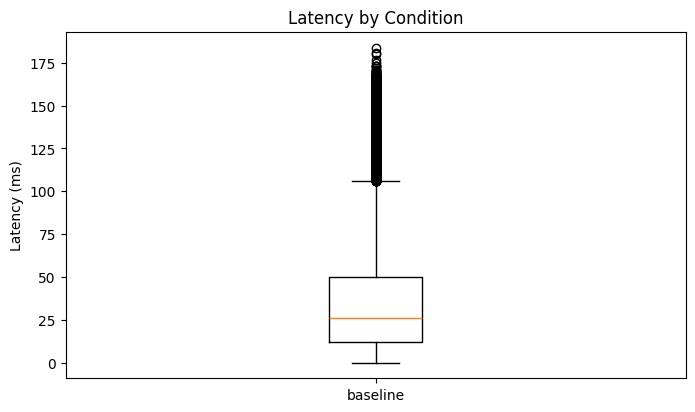

In [ ]:

# Side-by-side boxplot
import matplotlib.pyplot as plt
labels, data = [], []
for label, path in FILES.items():
    try:
        s = pd.read_csv(path, header=None, names=["lat_s"])["lat_s"].dropna()
        s = s[(s>=0) & (s<2.0)]
        data.append(s*1000.0); labels.append(label)
    except Exception:
        pass

if data:
    plt.figure(figsize=(6+2*len(data),4.5))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.ylabel("Latency (ms)")
    plt.title("Latency by Condition")
    plt.show()
else:
    print("No valid condition files provided.")


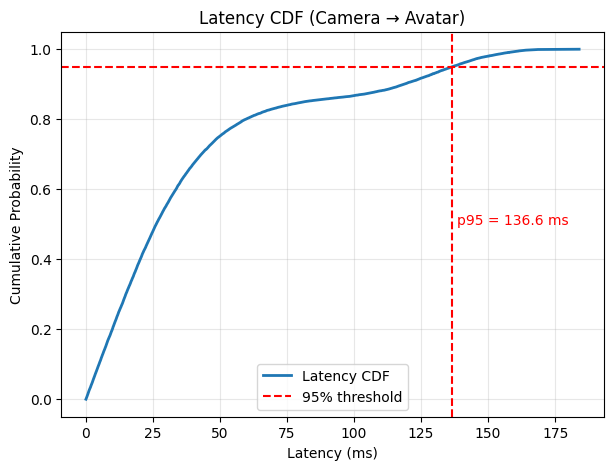

Median latency = 26.20 ms
95th percentile (p95) latency = 136.59 ms


In [ ]:
# Plot Latency CDF with labels & p95 marker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have DataFrame `df` with a column 'latency_ms'
latencies = lat_ms.values # Changed from df["latency_ms"].values to lat_ms.values
latencies = np.sort(latencies)
cdf = np.arange(1, len(latencies)+1) / len(latencies)

# Compute key metrics
median = np.median(latencies)
p95 = np.percentile(latencies, 95)

plt.figure(figsize=(7,5))
plt.plot(latencies, cdf, label="Latency CDF", linewidth=2)

# Add horizontal and vertical lines for the 95th percentile
plt.axhline(0.95, color="red", linestyle="--", linewidth=1.5, label="95% threshold")
plt.axvline(p95, color="red", linestyle="--", linewidth=1.5)

# Annotate the p95 point
plt.text(p95+2, 0.5, f"p95 = {p95:.1f} ms", color="red")

# Axis labels and title
plt.xlabel("Latency (ms)")
plt.ylabel("Cumulative Probability")
plt.title("Latency CDF (Camera → Avatar)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Median latency = {median:.2f} ms")
print(f"95th percentile (p95) latency = {p95:.2f} ms")

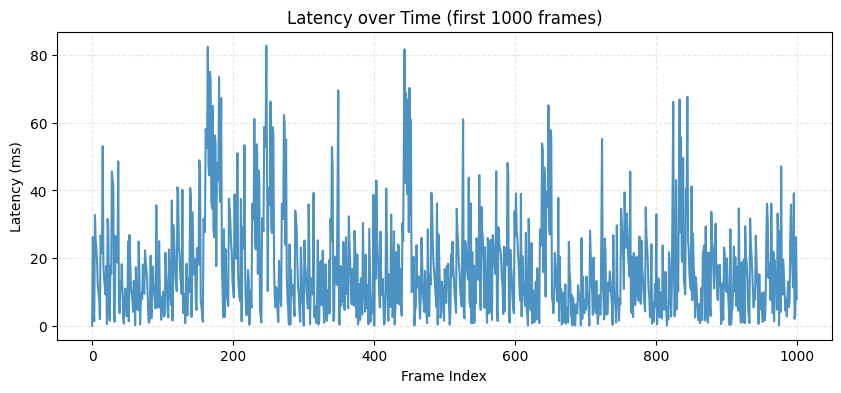

In [ ]:
# === Latency vs Frame Index (time series) ===
plt.figure(figsize=(10,4))
plt.plot(lat_ms.values[:1000], alpha=0.8)  # show first 1000 frames
plt.xlabel("Frame Index")
plt.ylabel("Latency (ms)")
plt.title("Latency over Time (first 1000 frames)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


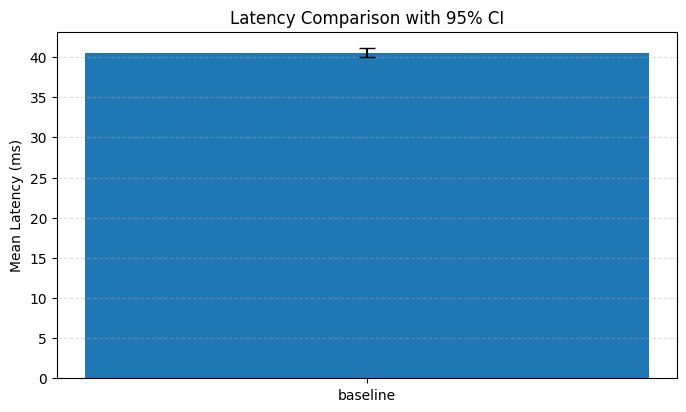

In [ ]:
# === Bar chart with error bars (conditions) ===
means = []
errors = []
labels = []

for label, path in FILES.items():
    try:
        s = pd.read_csv(path, header=None, names=["lat_s"])["lat_s"].dropna()
        s = s[(s>=0) & (s<2.0)]
        ms = s*1000.0
        mean_val = ms.mean()
        # bootstrap 95% CI for mean
        ci = bootstrap_ci(ms, np.mean, B=500)
        err = [[mean_val-ci[0]], [ci[1]-mean_val]]
        means.append(mean_val)
        errors.append(err)
        labels.append(label)
    except Exception as e:
        print("Error:", e)

plt.figure(figsize=(6+2*len(labels),4.5))
# Ensure yerr has the correct shape for plt.bar
if len(labels) == 1:
    yerr_array = np.array(errors).reshape(2, 1)
else:
    yerr_array = np.array(errors).squeeze().T

bars = plt.bar(labels, means, yerr=yerr_array, capsize=6)
plt.ylabel("Mean Latency (ms)")
plt.title("Latency Comparison with 95% CI")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


## Market Benchmarks (edit values and cite sources in your paper)

- OptiTrack (Virtual Production): system latency <10 ms (vendor reported).
- Vicon (Tracker processing): as low as ~1.5 ms (processing only).
- Azure Kinect Body Tracking: community reports ~250 ms end-to-end in some setups; SDK ~50 ms for body tracking stage.
- MediaPipe Hand Landmarker (Pixel 6): ~12–17 ms per hand inference (on-device).
- VR Motion-to-Photon: typical 10–50 ms; comfort threshold often cited <20 ms.

> Please verify and cite original sources in your paper.


In [ ]:
# Calculate and print standard deviation
std_dev_ms = lat_ms.std()
print(f"Standard Deviation (ms): {std_dev_ms:.2f}")

Standard Deviation (ms): 40.78


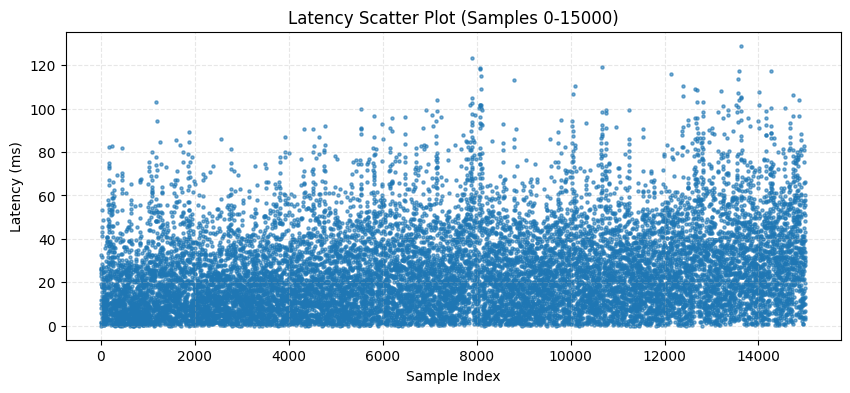

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(lat_ms.index[:15000], lat_ms.values[:15000], s=5, alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Latency (ms)")
plt.title("Latency Scatter Plot (Samples 0-15000)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()